# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0


When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

### 5.DDPG Agent

Bipedal DDPG implementation

In [5]:
from ddpg_agent import Agent
from collections import deque
import torch
import time
import matplotlib.pyplot as plt
%matplotlib inline

Episode 100	Average Score: 7.757	Score: 15.800
Episode 200	Average Score: 27.807	Score: 39.860
Episode 210	Average Score: 30.233	Score: 42.410
Environment solved in 210 episodes!	Average Score: 30.233
Episode 300	Average Score: 51.333	Score: 63.590

Time Elapse: 1842.115


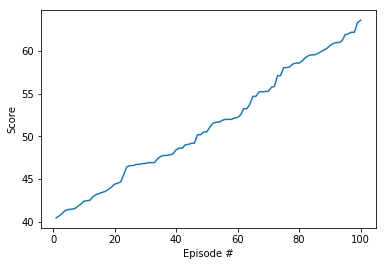

In [6]:
def ddpg(n_episodes=300, max_t=700):
    scores_deque = deque(maxlen=100)
    scores = np.zeros(num_agents)
    avg_score = []
    max_score = -np.Inf
    time_steps = 10
    update = 10
    
    env_info = env.reset(train_mode=True)[brain_name]
    
    start_time = time.time()     # Start time
    solved = False
    
    states = env_info.vector_observations
    agent_tuple = {"state_size": state_size, "action_size": action_size, "random_seed": 2,}
    agents = [Agent(**agent_tuple) for _ in range(num_agents)]
    action = [agent.act(states[i]) for i, agent in enumerate(agents)]
    
    for i_episode in range(1, n_episodes+1):
        states = env_info.vector_observations                 
        for agent in agents:
            agent.reset()
        #score = 0
        for t in range(max_t):
            #action = agent.act(state)
            actions = [agent.act(states[i]) for i, agent in enumerate(agents)]  
            #next_state, reward, done, _ = env.step(action)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards                         
            dones = env_info.local_done
            step_t = zip(agents, states, actions, rewards, next_states, dones)
            
            for agent, state, action, reward, next_step, done in step_t:
                agent.memory.add(state, action, reward, next_step, done)
                if ( t % time_steps == 0):
                    agent.step(state, action, reward, next_step, done, update)
            states = next_states
            scores += rewards                                  
            if np.any(dones):                                 
                break
            
            #agent.step(state, action, reward, next_state, done)
            #state = next_state
            #score += reward
            #if done:
            #    break 
        
        score = np.mean(scores)        
        avg_score.append(score)
        scores_deque.append(score)
        avg = np.mean(scores_deque)
        duration = time.time() - start_time
        
        print('\rEpisode {}\tAverage Score: {:.3f}\tScore: {:.3f}'.format(i_episode, np.mean(scores_deque), score), end="")
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_2.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_2.pth')
            print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) > 30 and solved == False:
            solved = True
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_deque)))
        
    time_elapsed = time.time() - start_time
    print("\nTime Elapse: {:.3f}".format(time_elapsed))
    
    return scores_deque

scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [12]:
scores

array([ 63.58999858])

NameError: name 'scores_deque' is not defined

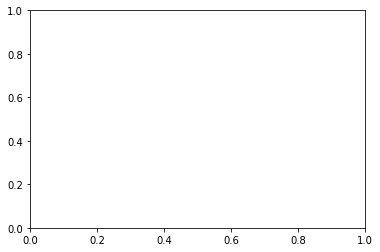

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores_deque)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Shangtong Zhang code

In [15]:
import torch
import time
from collections import deque
from DeepRL.deep_rl.agent.DDPG_agent import DDPGAgent
import matplotlib.pyplot as plt
%matplotlib inline

model_weight_name = 'model_weìghts.pth'

agent = DDPGAgent(state_size=37, action_size=4, seed=0)

TypeError: __init__() got an unexpected keyword argument 'state_size'

In [16]:
# DDPG
def ddpg_continuous(name):
    config = Config()
    log_dir = get_default_log_dir(ddpg_continuous.__name__)
    config.task_fn = lambda: Task(name)
    config.eval_env = Task(name, log_dir=log_dir)
    config.max_steps = int(1e6)
    config.eval_interval = int(1e4)
    config.eval_episodes = 20

    config.network_fn = lambda: DeterministicActorCriticNet(
        config.state_dim, config.action_dim,
        actor_body=FCBody(config.state_dim, (400, 300), gate=F.relu),
        critic_body=TwoLayerFCBodyWithAction(
            config.state_dim, config.action_dim, (400, 300), gate=F.relu),
        actor_opt_fn=lambda params: torch.optim.Adam(params, lr=1e-4),
        critic_opt_fn=lambda params: torch.optim.Adam(params, lr=1e-3))

    config.replay_fn = lambda: Replay(memory_size=int(1e6), batch_size=64)
    config.discount = 0.99
    config.random_process_fn = lambda: OrnsteinUhlenbeckProcess(
        size=(config.action_dim, ), std=LinearSchedule(0.2))
    config.min_memory_size = 64
    config.target_network_mix = 1e-3
    config.logger = get_logger()
    run_steps(DDPGAgent(config))

### 6. Train Agent

### 7. Watch a smart Agent

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [ ]:

# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('model_weight.pth'))

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score

while True:
    action = agent.act(state)                      # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

In [ ]:
env.close()